<a href="https://colab.research.google.com/github/clferreira1985/PUC_RJ-Pos_Ciencia_de_Dados_e_Analytics/blob/main/MVP_Sprint_2_B_Machine_Learning_e_Analytics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Imports das bibliotecas necessárias para executar o notebook

In [62]:
from google.colab import drive
import os
import pandas as pd
import numpy as np
import random
import math
import shutil
from PIL import Image
from datetime import datetime
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing.image import ImageDataGenerator
from keras import layers
from keras.callbacks import ModelCheckpoint
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers,models,Model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import class_weight, shuffle
import sklearn.metrics as skm
from sklearn.metrics import confusion_matrix, classification_report, f1_score
import itertools


## 2. Acessando e tratando os dados que serão a entrada do modelo de deep learning

No caso abaixo, as imagens estão organizadas em pastas dentro do meu google drive. Crio um dataset com as informações das imagens

In [ ]:
# Vamos pegar todos os arquivos dentro da pasta que armazenei todas as imagens e transformar em um dataset
%%time
folder_path = r"/content/drive/MyDrive/Puc - Pós em Ciência de Dados e Analytics /Redes Neurais/Dataset/Animais"

data = {"path_img": [] , "heights": [], "widths": [], "animal": []  }

category = os.listdir(folder_path)
for folder in category:
    folderpath = os.path.join(folder_path , folder)
    filelist = os.listdir(folderpath)
    for file in filelist:
        fpath = os.path.join(folderpath, file)
        data["path_img"].append(fpath)
        data["animal"].append(folder)
        img_shape = Image.open(fpath)
        data["heights"].append(img_shape.size[0])
        data["widths"].append(img_shape.size[1])

df = pd.DataFrame(data)


CPU times: user 7.92 s, sys: 3.25 s, total: 11.2 s
Wall time: 8min 29s


In [ ]:
#Convert animal to numbers
lb = LabelEncoder()
df['encoded_animal'] = lb.fit_transform(df['animal'])


In [ ]:
#Vamos mudar os nomes das linhas labels, para entender melhor
translate = {"mucca": "vaca",
             "cavallo": "cavalo",
             "farfalla": "borboleta",
             "cane": "cachorro",
             "gallina": "galinha",
             "gatto": "gato",
             "elefante": "elefante",
             "pecora":"ovelha",
             "scoiattolo":"esquilo",
             "ragno":"aranha"}

df['animal']=df['animal'].map(translate)
df['animal'].unique()


array(['vaca', 'cavalo', 'aranha', 'borboleta', 'ovelha', 'cachorro',
       'galinha', 'gato', 'elefante', 'esquilo'], dtype=object)

In [ ]:
#Crio um resumo do dataset criado

print("Tamanho do dataset: ", df.shape)
print("_______________________________________")
print("Valores null: ")
print(df.isnull().sum())
print("_______________________________________")
print("Valores únicos: ")
print(df.nunique())

print("_______________________________________")
print("Qnt de imagens por categoria : ")
print(df.animal.value_counts())

print("_______________________________________")
print("Informação do dataset: ")
print(df.info())

Tamanho do dataset:  (21708, 5)
_______________________________________
Valores null: 
path_img          0
heights           0
widths            0
animal            0
encoded_animal    0
dtype: int64
_______________________________________
Valores únicos: 
path_img          21708
heights             278
widths              453
animal               10
encoded_animal       10
dtype: int64
_______________________________________
Qnt de imagens por categoria : 
cachorro     4863
galinha      3098
cavalo       2623
borboleta    2112
vaca         1866
esquilo      1862
ovelha       1820
gato         1668
elefante     1446
aranha        350
Name: animal, dtype: int64
_______________________________________
Informação do dataset: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21708 entries, 0 to 21707
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   path_img        21708 non-null  object
 1   heights         21708 

In [ ]:
df.head()

,path_img,heights,widths,animal,encoded_animal
0,/content/drive/MyDrive/Puc - Pós em Ciência ...,300,209,vaca,6
1,/content/drive/MyDrive/Puc - Pós em Ciência ...,300,225,vaca,6
2,/content/drive/MyDrive/Puc - Pós em Ciência ...,300,225,vaca,6
3,/content/drive/MyDrive/Puc - Pós em Ciência ...,300,192,vaca,6
4,/content/drive/MyDrive/Puc - Pós em Ciência ...,300,156,vaca,6


<Axes: title={'center': 'Como está distribuido o dataset'}, ylabel='animal'>

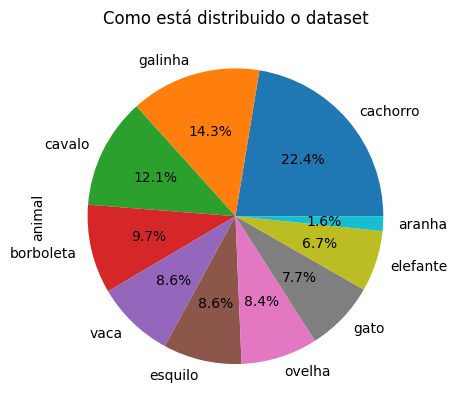

In [ ]:
#Visualizando como está dividido o conjunto de dados por classe
df['animal'].value_counts().plot.pie(title='Como está distribuido o dataset', autopct='%1.1f%%')

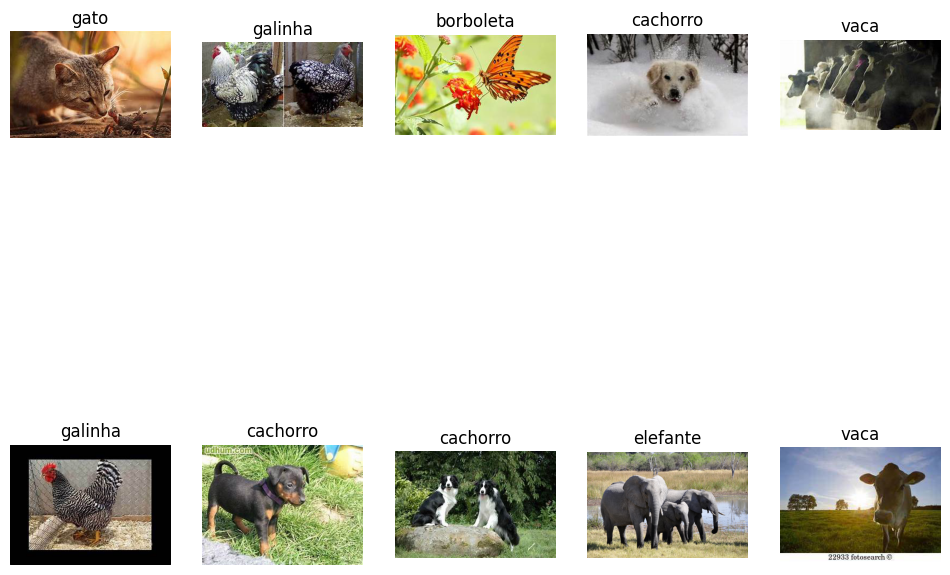

In [ ]:
#visualizando algumas imagens do conjunto de dados
plt.figure(figsize=(12,10))
for i, row in df.sample(n=10).reset_index().iterrows():
    plt.subplot(2,5,i+1)
    image_path = row['path_img']
    image = Image.open(image_path)
    plt.imshow(image)
    plt.title(row["animal"])
    plt.axis('off')
plt.show()

Divisão dos dados em treino e teste: 30% das imagens para teste e 70 para treino do modelo de deep learning.

In [53]:
df_train, df_tem = train_test_split(df[['path_img', 'animal', 'encoded_animal']].reset_index(drop=True), test_size=0.3, random_state=30, shuffle=True)
df_test, df_val = train_test_split(df_tem, test_size=0.6, random_state=30, shuffle=True)



In [54]:
#Resumo da separação do conjunto de dados
print("#########Train##############")
print(df_train.head())
print(df_train.shape)
print("#########Test###############")
print(df_test.head())
print(df_test.shape)
print("#########Validação###############")
print(df_val.head())
print(df_val.shape)

#########Train##############
                                                path_img     animal  \
141    /content/drive/MyDrive/Puc - Pós em Ciência ...       vaca   
2309   /content/drive/MyDrive/Puc - Pós em Ciência ...     cavalo   
12115  /content/drive/MyDrive/Puc - Pós em Ciência ...   cachorro   
5355   /content/drive/MyDrive/Puc - Pós em Ciência ...  borboleta   
17502  /content/drive/MyDrive/Puc - Pós em Ciência ...       gato   

       encoded_animal  
141                 6  
2309                1  
12115               0  
5355                3  
17502               5  
(15195, 3)
#########Test###############
                                                path_img     animal  \
1029   /content/drive/MyDrive/Puc - Pós em Ciência ...       vaca   
20119  /content/drive/MyDrive/Puc - Pós em Ciência ...    esquilo   
6414   /content/drive/MyDrive/Puc - Pós em Ciência ...  borboleta   
17974  /content/drive/MyDrive/Puc - Pós em Ciência ...       gato   
7752 

#### Preparação dos dados

Através da classe **ImageDataGenerator** do TensorFlow iremos configurar geradores de dados para o treinamento, validação, e teste

In [56]:
%%time

BATCH_SIZE = 30 #Defino o tamanho do lote
IMAGE_SIZE = (150, 150) #Defino o tamanho das imagens

generator=ImageDataGenerator(rescale=1./255)


train_generator=generator.flow_from_dataframe(
    dataframe=df_train,
    target_size= IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    x_col='path_img',
    y_col='animal',
    color_mode ='rgb',
    seed = 20,
    shuffle=False
    )

val_generator=generator.flow_from_dataframe(
    dataframe=df_val,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    x_col='path_img',
    y_col='animal',
    color_mode ='rgb',
    shuffle=False
    )

test_generator=generator.flow_from_dataframe(
    dataframe = df_test,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    x_col='path_img',
    y_col='animal',
    color_mode ='rgb',
    shuffle=False)

Found 15195 validated image filenames belonging to 10 classes.
Found 3908 validated image filenames belonging to 10 classes.
Found 2605 validated image filenames belonging to 10 classes.
CPU times: user 838 ms, sys: 565 ms, total: 1.4 s
Wall time: 5.58 s


Found 1 validated image filenames belonging to 1 classes.


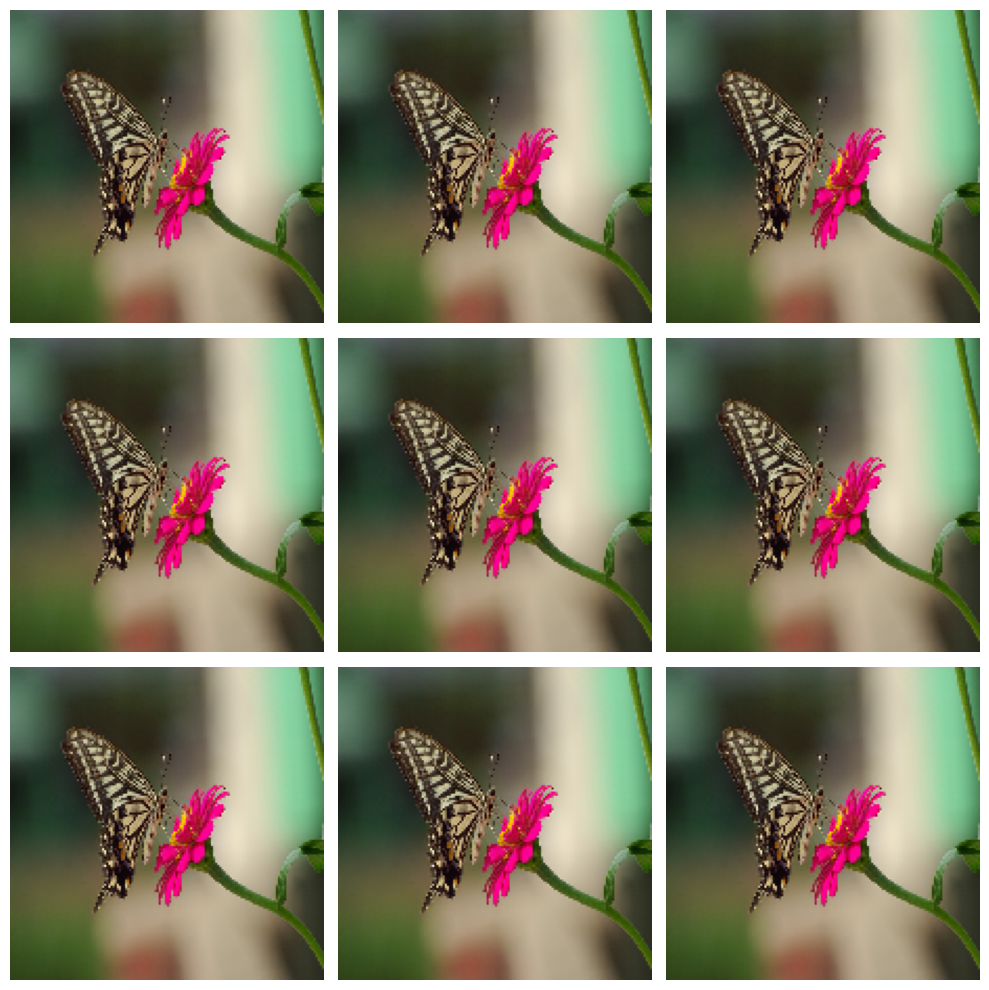

In [57]:
#Visualizo uma imagem com o class_mode="categorical"
sample = df.sample(n=1)

sample_generator = generator.flow_from_dataframe(
    dataframe = sample,
    x_col='path_img',
    y_col='animal',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    color_mode ='rgb',
)

plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i+1)
    for x_batch, y_batch in sample_generator:
        image = x_batch[0]
        plt.imshow(image)
        plt.axis('Off')
        break
plt.tight_layout()
plt.show()

## Configuração de um modelo de deep learning usando uma rede neural convolucional (CNN)

In [65]:
num_classes = len(set(train_generator.classes))

# Data Augmentation Step
augment = tf.keras.Sequential([
  preprocessing.RandomFlip("horizontal"),
  preprocessing.RandomRotation(0.2),
  preprocessing.RandomZoom(0.2),
  preprocessing.RandomContrast(0.2),
], name='AugmentationLayer')


inputs = layers.Input(shape=(150, 150, 3), name='inputLayer')
x = augment(inputs)
x = layers.Conv2D(32, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(64, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(128, (3, 3), activation='relu')(x)
x = layers.BatchNormalization()(x)

x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(256, (3, 3), activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)

x = layers.Flatten()(x)
x = layers.Dropout(0.25)(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.25)(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.25)(x)
x = layers.Dense(num_classes, activation='softmax')(x)
outputs = layers.Activation(activation="softmax", dtype=tf.float32, name='activationLayer')(x)

model = Model(inputs=inputs, outputs=outputs)


print(model.summary())


Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputLayer (InputLayer)     [(None, 150, 150, 3)]     0         
                                                                 
 AugmentationLayer (Sequenti  (None, 150, 150, 3)      0         
 al)                                                             
                                                                 
 conv2d_23 (Conv2D)          (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 74, 74, 32)       0         
 g2D)                                                            
                                                                 
 batch_normalization_2 (Batc  (None, 74, 74, 32)       128       
 hNormalization)                                                 
                                                           

## 4. Treinamento do modelo de deep learning

In [66]:
%%time

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit_generator(train_generator,
                    steps_per_epoch=75,
                    epochs=20,
                    validation_data=val_generator,
                    validation_steps=len(val_generator))

<timed exec>:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/20
75/75 [==============================] - 477s 6s/step - loss: 2.1816 - accuracy: 0.2713 - val_loss: 2.2539 - val_accuracy: 0.2088
Epoch 2/20
75/75 [==============================] - 511s 7s/step - loss: 2.1222 - accuracy: 0.3373 - val_loss: 2.2960 - val_accuracy: 0.1451
Epoch 3/20
75/75 [==============================] - 511s 7s/step - loss: 2.0983 - accuracy: 0.3613 - val_loss: 2.2025 - val_accuracy: 0.2454
Epoch 4/20
75/75 [==============================] - 505s 7s/step - loss: 2.0654 - accuracy: 0.3942 - val_loss: 2.1915 - val_accuracy: 0.2584
Epoch 5/20
75/75 [==============================] - 509s 7s/step - loss: 2.0526 - accuracy: 0.4029 - val_loss: 2.1407 - val_accuracy: 0.3170
Epoch 6/20
75/75 [==============================] - 541s 7s/step - loss: 2.0343 - accuracy: 0.4244 - val_loss: 2.1680 - val_accuracy: 0.2876
Epoch 7/20
75/75 [==============================] - 525s 7s/step - loss: 2.0236 - accuracy: 0.4351 - val_loss: 2.0604 - val_accuracy: 0.3946
Epoch 8/20
75

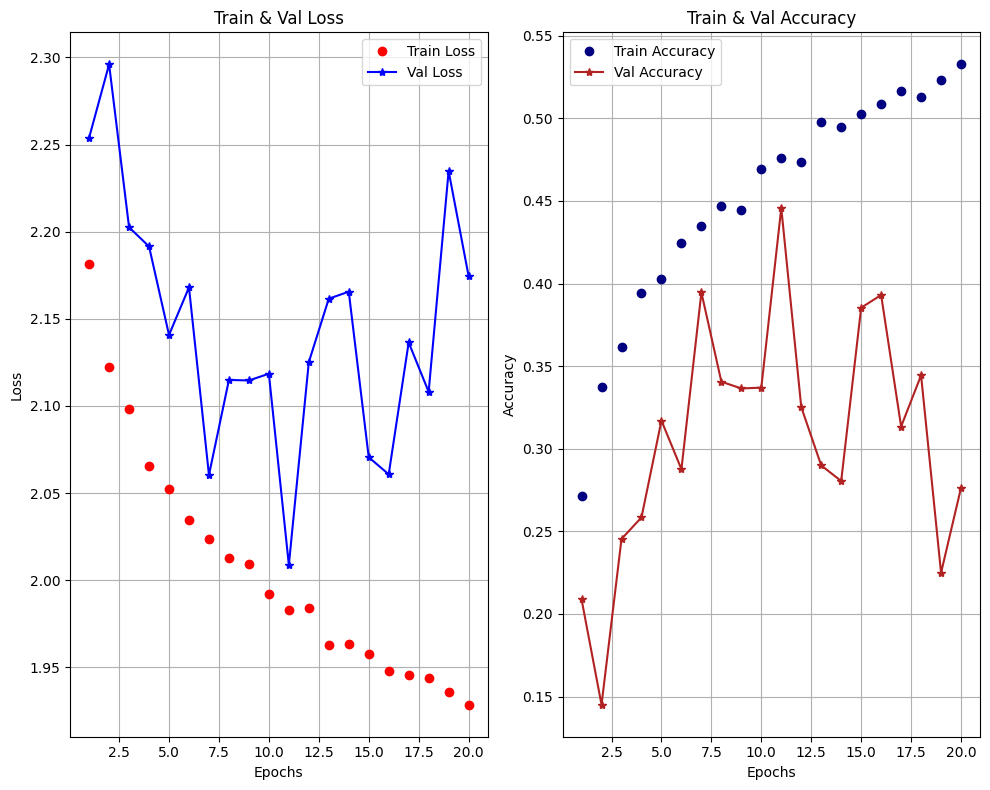

In [82]:
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 8))

epochs = range(1, len(history.history['accuracy'])+1)
loss_vals = history.history['loss']
val_loss_vals = history.history['val_loss']
acc_vals = history.history['accuracy']
val_acc_vals = history.history['val_accuracy']

ax[0].plot(epochs, loss_vals, color='Red', marker='o', linestyle=' ', label='Train Loss')
ax[0].plot(epochs, val_loss_vals, color='Blue', marker='*', label='Val Loss')
ax[0].set(title='Train & Val Loss', xlabel='Epochs', ylabel='Loss')
ax[0].legend(loc='best')
ax[0].grid(True)

ax[1].plot(epochs, acc_vals, color='navy', marker='o', ls=' ', label='Train Accuracy')
ax[1].plot(epochs, val_acc_vals, color='firebrick', marker='*', label='Val Accuracy')
ax[1].set(title='Train & Val Accuracy', xlabel='Epochs', ylabel='Accuracy')
ax[1].legend(loc='best')
ax[1].grid(True)

plt.tight_layout()
plt.show()


In [ ]:
count = 0
y_pred = list()
y_true = list()
class_names = ['cat', 'dog']

In [ ]:
y_true = np.array(test_generator)
y_true.shape

In [89]:
y_pred = []
y_true = []

show_plots(history.history)

for i in range(len(y_true)):
    plt.imshow(images[i])
    plt.axis('off')
    plt.show()
    print("Label: ", y_true[i])
    print("Previsão: ", y_pred[i])
    print("Probabilidade: ", probability[i])

NameError: ignored

In [ ]:
show_plots(history.history)


In [ ]:
loss, accuracy = model.evaluate(test_generator)
print("Test: accuracy = %f  ;  loss = %f " % (accuracy, loss))


In [ ]:
scores = model.evaluate(test_generator)
accuracy = scores[1]
y_true = test_generator.classes
y_pred = np.argmax(model.predict(test_generator), axis = 1)
f1 = f1_score(y_true, y_pred, average='weighted')
print("F1 Score:", f1)
print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))

In [117]:
y_true = np.array(test_generator.classes)
Y_true_shape=y_true.shape
y_pred = np.argmax(model.predict(test_generator), axis = 1)
print(Y_true_shape)
print(y_pred.shape)

44/44 [==============================] - 63s 1s/step
(2605,)
(2605,)


In [116]:
len(test_generator.labels)

2605

In [93]:
classes = dict(zip(test_generator.class_indices.values(), test_generator.class_indices.keys()))
Predictions = pd.DataFrame({"Image Index": list(range(len(test_generator.labels))),
                            "Test Labels": test_generator.labels,
                            "Test Classes": [classes[i] for i in test_generator.labels],
                            "Prediction Labels": y_pred,
                            "Prediction Classes": [classes[i] for i in y_pred],
                            "Path": test_generator.filepaths,
                            "Prediction Probability": [x for x in np.asarray(np.max(model.predict(test_generator), axis=1))]
                           })

44/44 [==============================] - 67s 2s/step


ValueError: ignored

In [91]:
plt.figure(figsize=(20, 20))
for i, row in Predictions[Predictions["Test Labels"] != Predictions["Prediction Labels"]].sort_values("Prediction Probability").tail(20).reset_index().iterrows():
    plt.subplot(5, 4, i+1)
    image_path = row['Path']
    image = Image.open(image_path)
    plt.imshow(image)
    plt.title(f'TRUE: {row["Test Classes"]} | PRED: {row["Prediction Classes"]}', fontsize=10)
    plt.axis('off')

plt.show()

NameError: ignored

<Figure size 2000x2000 with 0 Axes>